In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

In [4]:
df_iter = pd.read_csv("/kaggle/input/datasetintel/train_data.csv", chunksize=1_000_000) 
df_sample = pd.concat([chunk.sample(n=50_000, random_state=42) for chunk in df_iter]) 

In [5]:
#seperating independent and dependent variable 
X = df_sample[['w', 'x']]
y = df_sample['y']

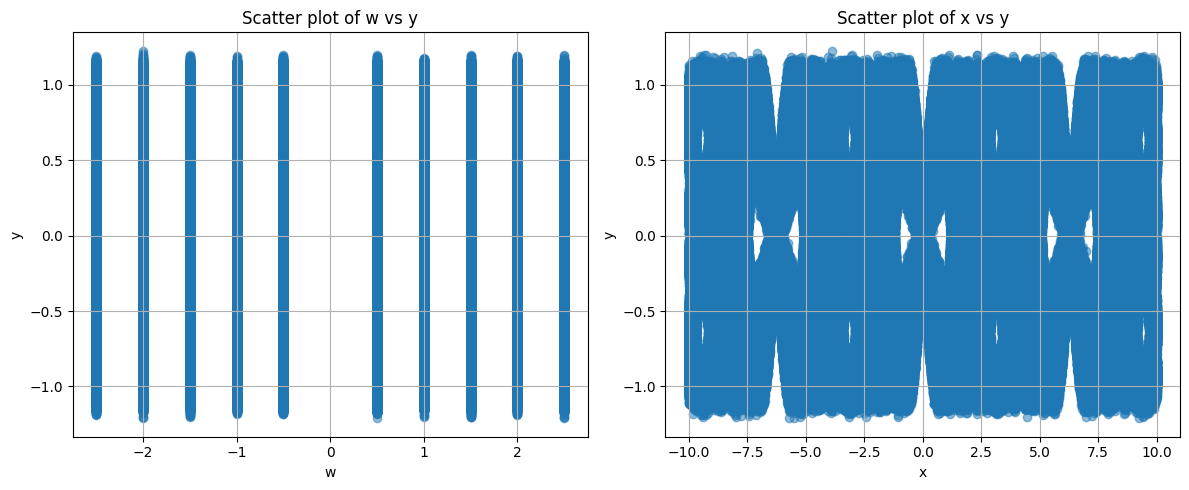

In [6]:
import matplotlib.pyplot as plt

# Plot 'w' vs 'y'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df_sample['w'], df_sample['y'], alpha=0.5)
plt.xlabel('w')
plt.ylabel('y')
plt.title('Scatter plot of w vs y')
plt.grid(True)

# Plot 'x' vs 'y'
plt.subplot(1, 2, 2)
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot of x vs y')
plt.grid(True)

plt.tight_layout()
plt.show()


First I tried to plot the relation between y and x , y and w .clearly from the graph , we can see that w has disrete values with respect to y . both  the graphs are periodic in nature .Since the gragh of x vs y is dense , it indicates that the graph has high frequency or many points per period .considering the below graph y maybe a sinosudial function with respect to w, x.

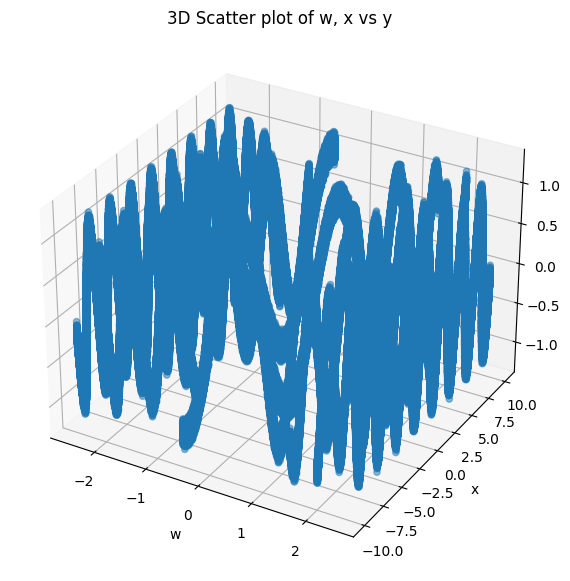

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_sample['w'], df_sample['x'], df_sample['y'], alpha=0.5)
ax.set_xlabel('w')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_title('3D Scatter plot of w, x vs y')

plt.show()


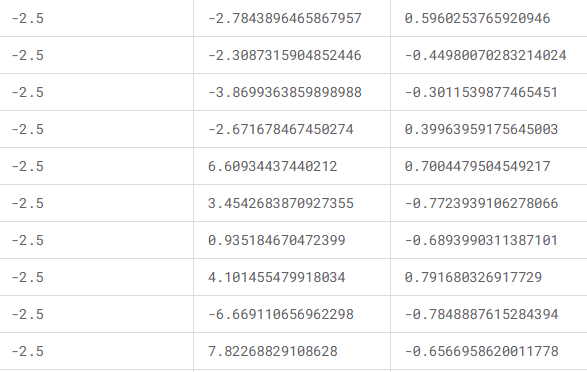

Also just going through the data, it indicates y cannot be of the form a(w) + b(x), because changing w would simply shift all the values of y up or down since x is sinusoidal function .

y=f(w,x) = a(w)sin(w,x)/a(w)cos(w,x) or y=sin(k*w*x) or y=cos(k*w*x) or sin(ax + bw) /cos(ax + bw) or may be sum of sin and cos 

Now just guessing some functions and calculating error . I have kept on trying with other possible combinations of x,w .

In [8]:
import numpy as np
import pandas as pd

#1
df_sample['y_pred1'] = np.cos(df_sample['w'] * df_sample['x'])
df_sample['y_pred2'] = np.sin(df_sample['w'] * df_sample['x'])

# Calculate error
df_sample['error1'] = df_sample['y'] - df_sample['y_pred1']
df_sample['error2'] = df_sample['y'] - df_sample['y_pred2']


print(df_sample[['w', 'x', 'y', 'y_pred1', 'error1']].head(10000000))
print(df_sample[['w', 'x', 'y', 'y_pred1', 'error2']].head(10000000))


print("Mean absolute error1:", np.abs(df_sample['error1']).mean())
print("Max absolute error1:", np.abs(df_sample['error1']).max())
print("Min absolute error1:", np.abs(df_sample['error1']).min())
print("Mean absolute error2:", np.abs(df_sample['error2']).mean())
print("Max absolute error2:", np.abs(df_sample['error2']).max())
print("Min absolute error2:", np.abs(df_sample['error2']).min())


            w         x         y   y_pred1    error1
987231   -2.5  3.867848  0.261195 -0.970175  1.231371
79954    -2.5 -2.480476 -0.186295  0.996640 -1.182936
567130   -2.5 -9.704341 -0.779432  0.643382 -1.422814
500891   -2.5  2.119825  0.828073  0.554010  0.274063
55399    -2.5  1.384339  0.257587 -0.949470  1.207057
...       ...       ...       ...       ...       ...
99662925  2.5  5.354522  0.738732  0.682270  0.056462
99649864  2.5  9.112567 -0.668431 -0.703655  0.035224
99331385  2.5  7.570586  0.096077  0.997044 -0.900967
99699967  2.5  0.974336  0.679829 -0.761123  1.440952
99120934  2.5  1.645399 -0.853025 -0.563727 -0.289298

[5000000 rows x 5 columns]
            w         x         y   y_pred1    error2
987231   -2.5  3.867848  0.261195 -0.970175  0.018791
79954    -2.5 -2.480476 -0.186295  0.996640 -0.104391
567130   -2.5 -9.704341 -0.779432  0.643382 -0.013887
500891   -2.5  2.119825  0.828073  0.554010 -0.004437
55399    -2.5  1.384339  0.257587 -0.949470 -0.056272


In [9]:
from sklearn.metrics import r2_score

# R2 calculation
r2 = r2_score(df_sample['y'], df_sample['y_pred1'])
print("R^2 Score1:", r2)
r2 = r2_score(df_sample['y'], df_sample['y_pred2'])
print("R^2 Score2:", r2)


R^2 Score1: -0.9822880126819666
R^2 Score2: 0.9950534033005379


R^2 is very high for the function y=sin(w*x) and y cannot be the function y=cos(w*x) . But this is only theoretical .

In [10]:
df_sample['y_pred'] = np.sin(df_sample['w'] * df_sample['x'])

Fitted parameters: [6.73586253e-06 1.00079022e+00 5.23223303e-05 9.99190058e-01]
R^2 Score: 0.9950413783025185
Mean Absolute Error: 0.039923953191286894


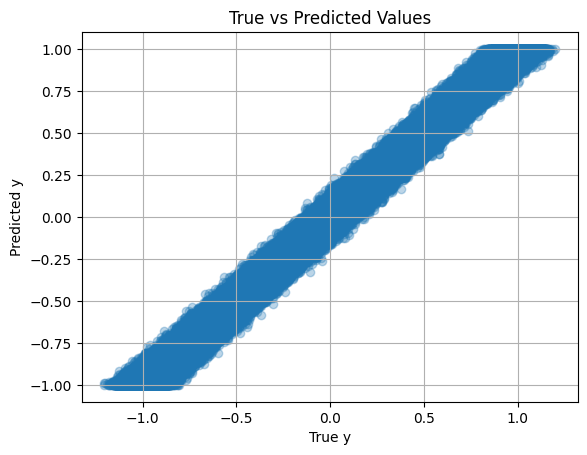

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error

#theoretical
initial_params = [0, 1, 0, 1]


def model(X, a0, a1, b0, b1):
    w, x = X
    A = a0 + a1 * w      
    B = b0 + b1 * x       
    return  np.sin(A * B)



df_sample_small = df_sample.sample(frac=0.1, random_state=42)  

X_small = np.vstack((df_sample_small['w'].values, df_sample_small['x'].values))
y_small = df_sample_small['y'].values

# Then fit on this smaller sample
params, cov = curve_fit(model, X_small, y_small, p0=initial_params, maxfev=10000)

# Predict on the sampled data
y_pred_small = model(X_small, *params)

r2 = r2_score(y_small, y_pred_small)
mae = mean_absolute_error(y_small, y_pred_small)




print("Fitted parameters:", params)
print("R^2 Score:", r2)
print("Mean Absolute Error:", mae)


import matplotlib.pyplot as plt

plt.scatter(y_small, y_pred_small, alpha=0.3)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("True vs Predicted Values")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Load test data
test_df = pd.read_csv("/kaggle/input/datasetintel/test_data.csv")  

a0, a1, b0, b1 = params  
w = test_df['w'].values
x = test_df['x'].values

# Predict using fitted parameter model
y_pred = np.sin((a0 + a1 * w) * (b0 + b1 * x))

# Attach predictions to dataframe
test_df['y_pred'] = y_pred


test_df[['y_pred']].to_csv("test_predictions.csv", index=False)

print("Predictions saved to test_predictions.csv")


Predictions saved to test_predictions.csv


In [17]:
test_df[:100]

,w,x,y_pred
0,-2.5,-20.640539,0.972222
1,-2.5,21.636451,0.631073
2,-2.5,-16.856414,-0.963351
3,-2.5,89.961916,0.962191
4,-2.5,13.535599,-0.658762
...,...,...,...
95,-2.5,-20.102518,-0.010477
96,-2.5,-16.789342,-0.905074
97,-2.5,62.027663,0.903417
98,-2.5,-89.587595,-0.789881
